In [3]:
! pip install --q evaluate

In [4]:
import os
import re
import numpy as np

from pathlib import Path

import pandas as pd
import torch
import evaluate

from torch import nn
from tqdm.notebook import tqdm
from tokenizers import Tokenizer
from tokenizers import normalizers
from tokenizers import pre_tokenizers
from tokenizers.models import WordLevel, WordPiece
from tokenizers.processors import TemplateProcessing


from torch.utils.data import DataLoader, Dataset, Subset

from tokenizers.normalizers import NFC, StripAccents, Strip, Lowercase
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordLevelTrainer, WordPieceTrainer

from sklearn.model_selection import train_test_split

2024-11-23 11:59:01.778564: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-23 11:59:01.778719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-23 11:59:01.905721: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# TODO : Class of myParameters

class Variables :
    TEXT ={
        #'vocab_size' : 200_000,
        'seq_len':20,
        'batch':32
    }
    TRANSFORMER = {
        'heads':16,
        'latent_dim':512,
        'pf_dim':1024,
        'dropout':0.25,
        'encoder_layers':3,
        'decoder_layers':3,
    }
    TRAIN = {
    'epoch'  : 500,
    'lr'     : 1e-4,
    }
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
var = Variables()

In [6]:
# TODO : Cleaning data
punc_re = re.compile(r"""[!"#$%&\'()*+,-./:;<=>?@[\\\]^_`{|}~،؟…«“\":\"…”]""")
def remove_punctation(text: str) -> str:
    return punc_re.sub(repl="", string=text)


diactircs_re = re.compile("[\u064B-\u0652]")
def remove_diactrics(text: str) -> str:
    return diactircs_re.sub(repl="", string=text)

def clean_text(text: str) -> str:
    return remove_punctation(remove_diactrics(text))


In [7]:
# TODO : utilities of creation and preparation data 

class TranslationDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        # Ensure the 'length' column exists
        df['length'] = df['source'].apply(len)
        self.df = df.sort_values(by="length")
        
        self.src = self.df["source"].tolist()
        self.trg = self.df["target"].tolist()
        
    def __getitem__(self, idx):
        source = self.src[idx]
        target = self.trg[idx]
        return (source, target)
        
    def __len__(self):
        return len(self.df)


def prepare_batch(batch, en_tokenizer: Tokenizer, ur_tokenizer: Tokenizer):
    en = list(map(lambda x: x[0], batch))
    ur = list(map(lambda x: x[1], batch))
    
    
    en = en_tokenizer.encode_batch(en)
    ur = ur_tokenizer.encode_batch(ur)
    
    
    
    en_tokens = list(map(lambda x: x.ids, en))
    en_mask = list(map(lambda x: x.attention_mask, en))
    ur_tokens = list(map(lambda x: x.ids, ur))
    ur_mask = list(map(lambda x: x.attention_mask, ur))

    
    source = torch.tensor(en_tokens)
    source_mask = torch.tensor(en_mask)
    target = torch.tensor(ur_tokens)
    target_mask = torch.tensor(ur_mask)
    return (source, source_mask, target, target_mask)

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(
        self,
        latent_dim: int,
        n_heads: int,
        dropout: float
    ):
        super().__init__()
        
        self.latent_dim = latent_dim
        self.n_heads = n_heads
        self.head_dim = self.latent_dim // self.n_heads
        
        self.fc_q = nn.Linear(in_features=self.latent_dim, out_features=self.latent_dim)
        self.fc_k = nn.Linear(in_features=self.latent_dim, out_features=self.latent_dim)
        self.fc_v = nn.Linear(in_features=self.latent_dim, out_features=self.latent_dim)
        
        self.fc_o = nn.Linear(in_features=self.latent_dim, out_features=self.latent_dim)
        
        self.dropout = nn.Dropout(p=dropout)
        
        
    def forward(self, query, key, value, mask = None):
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(query)
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / scale
        
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = self.dropout(torch.softmax(energy, dim=-1))        
        x = torch.matmul(attention, V)
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(batch_size, -1, self.latent_dim)
        x = self.fc_o(x)
        
        return x, attention
    

In [10]:
class PositionWiseFeedForward(nn.Module):
    def __init__(
        self,
        latent_dim: int,
        pf_dim: int,
        dropout: float
    ):        
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=latent_dim, out_features=pf_dim)
        self.fc2 = nn.Linear(in_features=pf_dim, out_features=latent_dim)
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [11]:
class EncoderLayer(nn.Module):
    def __init__(
        self,
        latent_dim: int,
        n_heads: int,
        pf_dim: int,
        dropout: float
    ):
        super().__init__()
        
        self.attention = MultiHeadAttention(latent_dim=latent_dim, n_heads=n_heads, dropout=dropout)
        self.positionwise_feedforward = PositionWiseFeedForward(latent_dim=latent_dim, pf_dim=pf_dim, dropout=dropout)
        
        self.attn_norm = nn.LayerNorm(normalized_shape=latent_dim)
        self.ppff_norm = nn.LayerNorm(normalized_shape=latent_dim)
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, src, src_mask):
        attention_values, _ = self.attention(src, src, src, src_mask)        
        output = (attention_values + src)        
        ppff = self.positionwise_feedforward(output)
        output = self.ppff_norm(output + self.dropout(ppff))
        
        return output

In [12]:
class Encoder(nn.Module):
    def __init__(
        self, 
        vocab_size: int,
        latent_dim: int,
        n_layers: int,
        n_heads: int,
        pf_dim: int,
        dropout: float
    ):
        super().__init__()
        
        
        self.tok_embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=latent_dim)
        self.pos_embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=latent_dim)
        
        self.layers = nn.ModuleList(
            [
                EncoderLayer(
                    latent_dim=latent_dim,
                    n_heads=n_heads,
                    pf_dim=pf_dim,
                    dropout=dropout
                )
                for _ in range(n_layers)]
        )
    
        self.dropout = nn.Dropout(p=dropout)

    
    def forward(self, src, src_mask):
        batch_size, src_len = src.shape
        
        positions = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(src)
        
        scale = torch.sqrt(torch.FloatTensor([self.tok_embedding.embedding_dim])).to(src)
        token_embeddings = self.tok_embedding(src) * scale
        positional_embeddings = self.pos_embedding(positions)
        
        output = self.dropout(token_embeddings + positional_embeddings)
        
        for layer in self.layers:
            output = layer(output, src_mask)
        
        return output

In [13]:
class DecoderLayer(nn.Module):
    def __init__(
        self,
        latent_dim: int,
        n_heads: int,
        pf_dim: int,
        dropout: float
    ):
        super().__init__()
        
        self.self_attention = MultiHeadAttention(
            latent_dim=latent_dim, 
            n_heads=n_heads,
            dropout=dropout
        )
        self.encoder_attention = MultiHeadAttention(
            latent_dim=latent_dim, 
            n_heads=n_heads, 
            dropout=dropout
        )
        self.positionwise_feedfoward = PositionWiseFeedForward(
            latent_dim=latent_dim, 
            pf_dim=pf_dim, 
            dropout=dropout
        )
        
        self.self_attn_norm = nn.LayerNorm(normalized_shape=latent_dim)
        self.enc_attn_norm = nn.LayerNorm(normalized_shape=latent_dim)
        self.pff_norm = nn.LayerNorm(normalized_shape=latent_dim)
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, trg, enc_out, trg_mask, src_mask):
        self_attention, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        output = self.self_attn_norm(trg + self.dropout(self_attention))
        
        encoder_attention, attention_scores = self.encoder_attention(output, enc_out, enc_out, src_mask)
        
        output = self.enc_attn_norm(output + self.dropout(encoder_attention))
        
        pwff = self.positionwise_feedfoward(output)
        output = self.pff_norm(output + self.dropout(pwff))
        
        return output, attention_scores

In [14]:
class Decoder(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        latent_dim: int,
        n_layers: int,
        n_heads: int,
        pf_dim: int,
        dropout: float,
        max_len: int = 100
    ):
        super().__init__()
        self.latent_dim = latent_dim
        
        self.tok_embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=latent_dim)
        self.pos_embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=latent_dim)
        
        self.layers = nn.ModuleList(
            [
                DecoderLayer(latent_dim=latent_dim, n_heads=n_heads, pf_dim=pf_dim, dropout=dropout)
                for _ in range(n_layers)
            ]
        )
        
        self.fc_out = nn.Linear(in_features=latent_dim, out_features=vocab_size)
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, trg, enc_out, trg_mask, src_mask):
        
        batch_size, trg_len = trg.shape
        
        positions = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(trg)
        
        scale = torch.sqrt(torch.FloatTensor([self.latent_dim])).to(trg)
        output = (self.tok_embedding(trg) * scale) + self.pos_embedding(positions)
        output = self.dropout(output)
        
        for layer in self.layers:
            output, attention = layer(output, enc_out, trg_mask, src_mask)
        
        output = self.dropout(output)
        output = self.fc_out(output)
        
        return output, attention

In [15]:
class Seq2Seq(nn.Module):
    def __init__(
        self,
        encoder: nn.Module,
        decoder: nn.Module,
    ):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def make_trg_mask(self, trg_pad_mask):
        # trg_pad_mask = [batch_size, trg_len]
        trg_len = trg_pad_mask.shape[1]
        
        trg_pad_mask = trg_pad_mask.unsqueeze(1).unsqueeze(2)
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len))).to(trg_pad_mask).bool()
        
        trg_mask = trg_pad_mask & trg_sub_mask
        
        return trg_mask
    
    def make_src_mask(self, src_pad_mask):
        return src_pad_mask.unsqueeze(1).unsqueeze(2)
    
    def forward(self, src, trg, src_mask, trg_mask):
        
        src_mask = self.make_src_mask(src_pad_mask=src_mask)
        trg_mask = self.make_trg_mask(trg_pad_mask=trg_mask)
        encoder_outputs = self.encoder(src, src_mask)
        output, attention = self.decoder(trg, encoder_outputs, trg_mask, src_mask)
        
        return output, attention

<hr>

In [16]:
import pandas as pd

# Define file paths
file_path_en = "/kaggle/input/umc005/bible/train.en"
file_path_ur = "/kaggle/input/umc005/bible/train.ur"

# Read and store the content in DataFrame
try:
    # Open files
    with open(file_path_en, "r", encoding="utf-8") as file_en, open(file_path_ur, "r", encoding="utf-8") as file_ur:
        # Read lines
        english_lines = [line.strip() for line in file_en.readlines()]
        urdu_lines = [line.strip() for line in file_ur.readlines()]

    # Create DataFrame
    data = pd.DataFrame({"source": english_lines, "target": urdu_lines})
    
    # Display first few rows
    print(data.head())
except FileNotFoundError as e:
    print(f"File not found: {e}")
except Exception as e:
    print(f"An error occurred: {e}")


                                              source  \
0  ﻿The book of the generation of Jesus Christ , ...   
1  Abraham begat Isaac ; and Isaac begat Jacob ; ...   
2  And Judas begat Phares and Zara of Thamar ; an...   
3  And Aram begat Aminadab ; and Aminadab begat N...   
4  And Salmon begat Booz of Rachab ; and Booz beg...   

                                              target  
0         ﻿یسوع مسیح ابن داود ابن ابرہام کا نسب نامہ  
1  ابراہام سے اضحاق پیدا ہوا اور اضحاق سے یعقوب پ...  
2  اور یہوداہ سے فارص اور زارح تمر سے پیدا ہوئے ا...  
3  اور رام سے عمینداب پیدا ہوا اور عمینداب سے نحس...  
4  اور سلمون سے بوعز راحب سے پیدا ہوا اور بوعز سے...  


In [17]:
# TODO : Data Insight
data.head(10)

,source,target
0,"﻿The book of the generation of Jesus Christ , ...",﻿یسوع مسیح ابن داود ابن ابرہام کا نسب نامہ
1,Abraham begat Isaac ; and Isaac begat Jacob ; ...,ابراہام سے اضحاق پیدا ہوا اور اضحاق سے یعقوب پ...
2,And Judas begat Phares and Zara of Thamar ; an...,اور یہوداہ سے فارص اور زارح تمر سے پیدا ہوئے ا...
3,And Aram begat Aminadab ; and Aminadab begat N...,اور رام سے عمینداب پیدا ہوا اور عمینداب سے نحس...
4,And Salmon begat Booz of Rachab ; and Booz beg...,اور سلمون سے بوعز راحب سے پیدا ہوا اور بوعز سے...
5,And Jesse begat David the king ; and David the...,اور یسی سے داود بادشاہ پیدا ہوا ۔ اور داود سے ...
6,And Solomon begat Roboam ; and Roboam begat Ab...,اور سلیمان سے رحبعام پیدا ہوا اور رحبعام سے اب...
7,And Asa begat Josaphat ; and Josaphat begat Jo...,اور آسا سے یہوسفط پیدا ہوا اور یہوسفط سے یورام...
8,And Ozias begat Joatham ; and Joatham begat Ac...,اور عزیاہ سے یوتام پیدا ہوا اور یوتام سے آخز پ...
9,And Ezekias begat Manasses ; and Manasses bega...,اور حزقیا سے منسی پیدا ہوا اور منسی سے امون پی...


In [18]:
print(f"Total samples = {len(data)}")

Total samples = 7400


## Preprocess Data

In [19]:
# TODO : Apply Preprocessing 
# 01-Clean
data["target"] = data["target"].map(clean_text)
data["source"] = data["source"].map(clean_text)

# 02-remove duplicate
print(f"Number of Duplicated data {data['target'].duplicated(keep='first').sum()}")
data = data.copy(deep=True)[~data.duplicated()]

print(f'Shape Of Data : {data.shape}')

Number of Duplicated data 16
Shape Of Data : (7394, 2)


In [20]:
# TODO : Show Length
data["length"] = data["source"].map(lambda x: len(x.split(" ")))

data.describe()

,length
count,7394.000000
mean,26.029619
std,9.497396
min,3.000000
25%,19.000000
50%,25.000000
75%,32.000000
max,71.000000


In [21]:
import pandas as pd

# Define file paths
file_path_en = "/kaggle/input/umc005/bible/train.en"
file_path_ur = "/kaggle/input/umc005/bible/train.ur"

# Read and store the content in DataFrame
try:
    # Open files
    with open(file_path_en, "r", encoding="utf-8") as file_en, open(file_path_ur, "r", encoding="utf-8") as file_ur:
        # Read lines
        english_lines = [line.strip() for line in file_en.readlines()]
        urdu_lines = [line.strip() for line in file_ur.readlines()]

    # Create DataFrame
    train = pd.DataFrame({"source": english_lines, "target": urdu_lines})
    
    # Display first few rows
    print(data.head())
except FileNotFoundError as e:
    print(f"File not found: {e}")
except Exception as e:
    print(f"An error occurred: {e}")


                                              source  \
0  ﻿The book of the generation of Jesus Christ  t...   
1  Abraham begat Isaac  and Isaac begat Jacob  an...   
2  And Judas begat Phares and Zara of Thamar  and...   
3  And Aram begat Aminadab  and Aminadab begat Na...   
4  And Salmon begat Booz of Rachab  and Booz bega...   

                                              target  length  
0         ﻿یسوع مسیح ابن داود ابن ابرہام کا نسب نامہ      19  
1  ابراہام سے اضحاق پیدا ہوا اور اضحاق سے یعقوب پ...      17  
2  اور یہوداہ سے فارص اور زارح تمر سے پیدا ہوئے ا...      19  
3  اور رام سے عمینداب پیدا ہوا اور عمینداب سے نحس...      15  
4  اور سلمون سے بوعز راحب سے پیدا ہوا اور بوعز سے...      19  


In [22]:
train.head(10)

,source,target
0,"﻿The book of the generation of Jesus Christ , ...",﻿یسوع مسیح ابن داود ابن ابرہام کا نسب نامہ
1,Abraham begat Isaac ; and Isaac begat Jacob ; ...,ابراہام سے اضحاق پیدا ہوا اور اضحاق سے یعقوب پ...
2,And Judas begat Phares and Zara of Thamar ; an...,اور یہوداہ سے فارص اور زارح تمر سے پیدا ہوئے ا...
3,And Aram begat Aminadab ; and Aminadab begat N...,اور رام سے عمینداب پیدا ہوا اور عمینداب سے نحس...
4,And Salmon begat Booz of Rachab ; and Booz beg...,اور سلمون سے بوعز راحب سے پیدا ہوا اور بوعز سے...
5,And Jesse begat David the king ; and David the...,اور یسی سے داود بادشاہ پیدا ہوا ۔ اور داود سے ...
6,And Solomon begat Roboam ; and Roboam begat Ab...,اور سلیمان سے رحبعام پیدا ہوا اور رحبعام سے اب...
7,And Asa begat Josaphat ; and Josaphat begat Jo...,اور آسا سے یہوسفط پیدا ہوا اور یہوسفط سے یورام...
8,And Ozias begat Joatham ; and Joatham begat Ac...,اور عزیاہ سے یوتام پیدا ہوا اور یوتام سے آخز پ...
9,And Ezekias begat Manasses ; and Manasses bega...,اور حزقیا سے منسی پیدا ہوا اور منسی سے امون پی...


In [23]:
# # TODO : Shuffle and Split Data
# train, test = train_test_split(data,random_state=42)
# len(train), len(test)
import pandas as pd

# Define file paths for test data
file_path_test_en = "/kaggle/input/umc005/bible/test.en"
file_path_test_ur = "/kaggle/input/umc005/bible/test.ur"

# Read and store the content in DataFrame
try:
    # Open test files
    with open(file_path_test_en, "r", encoding="utf-8") as file_test_en, open(file_path_test_ur, "r", encoding="utf-8") as file_test_ur:
        # Read lines from test files
        test_english_lines = [line.strip() for line in file_test_en.readlines()]
        test_urdu_lines = [line.strip() for line in file_test_ur.readlines()]

    # Create test DataFrame
    test = pd.DataFrame({"source": test_english_lines, "target": test_urdu_lines})
    
    # Display first few rows of the test DataFrame
    print(test.head())
except FileNotFoundError as e:
    print(f"File not found: {e}")
except Exception as e:
    print(f"An error occurred: {e}")


                                              source  \
0  And to them it was given that they should not ...   
1  And in those days shall men seek death , and s...   
2  And the shapes of the locusts were like unto h...   
3  And they had hair as the hair of women , and t...   
4  And they had breastplates , as it were breastp...   

                                              target  
0  اور انہیں جان سے مارنے کا نہیں بلکہ پانچ مہینے...  
1  ان دنوں میں آدمی موت ڈھونڈیں گے مگر ہرگز نہ پا...  
2  اور ان ڈڈیوں کی صورتیں ان گھوڑوں کی سی تھیں جو...  
3      اور بال عورتوں کے سے تھے اور دانت ببر کے سے ۔  
4  ان کے پاس لوہے کے سے بکتر تھے اور ان کے پروں ک...  


In [24]:
test.head(10)

,source,target
0,And to them it was given that they should not ...,اور انہیں جان سے مارنے کا نہیں بلکہ پانچ مہینے...
1,"And in those days shall men seek death , and s...",ان دنوں میں آدمی موت ڈھونڈیں گے مگر ہرگز نہ پا...
2,And the shapes of the locusts were like unto h...,اور ان ڈڈیوں کی صورتیں ان گھوڑوں کی سی تھیں جو...
3,"And they had hair as the hair of women , and t...",اور بال عورتوں کے سے تھے اور دانت ببر کے سے ۔
4,"And they had breastplates , as it were breastp...",ان کے پاس لوہے کے سے بکتر تھے اور ان کے پروں ک...
5,"And they had tails like unto scorpions , and t...",اور ان کی دمیں بچھوؤں کی سی تھیں اور ان میں ڈ...
6,"And they had a king over them , which is the a...",اتھاہ گڑھے کا فرشتہ ان پر بادشاہ تھا ۔ اس کا ن...
7,"One woe is past ; and , behold , there come tw...",پہلا افسوس تو ہو چکا ۔ دیکھو اس کے بعد دو افسو...
8,"And the sixth angel sounded , and I heard a vo...",اور جب چھٹے فرشتہ نے نرسنگا پھونکا تو میں نے ا...
9,Saying to the sixth angel which had the trumpe...,کہ اس چھٹے فرشتہ سے جس کے پاس نرسنگا تھا کوئی ...


In [25]:
# TODO : tokenization
normalizer = normalizers.Sequence([NFC(), StripAccents(), Lowercase(), Strip()])

In [26]:
# TODO : add spcial tokens
post_processor = TemplateProcessing(
    single="[SOS] $A [EOS]",
    special_tokens=[("[SOS]", 2), ("[EOS]", 3)]
)

en_tokenizer = Tokenizer(model=WordLevel(unk_token="[OOV]"))
ur_tokenizer = Tokenizer(model=WordLevel(unk_token="[OOV]"))

pre_tokenizer = pre_tokenizers.Sequence([Whitespace()])

In [27]:
en_tokenizer.normalizer = normalizer
en_tokenizer.pre_tokenizer = pre_tokenizer

ur_tokenizer.normalizer = normalizer
ur_tokenizer.pre_tokenizer = pre_tokenizer

en_tokenizer.enable_padding(direction='right')
ur_tokenizer.enable_padding(direction='right')


en_tokenizer.post_processor = post_processor
ur_tokenizer.post_processor = post_processor

In [28]:
trainer = WordLevelTrainer(vocab_size=200000, show_progress=False, min_frequency=5, 
                           special_tokens=["[PAD]", "[OOV]", "[SOS]", "[EOS]"]
                          )

en_tokenizer.train_from_iterator(iterator=data["source"].tolist(), trainer=trainer)
ur_tokenizer.train_from_iterator(iterator=data["target"].tolist(), trainer=trainer)

In [29]:
 list(en_tokenizer.get_vocab().items())[:10]


[('nevertheless', 523),
 ('nay', 720),
 ('escaped', 1215),
 ('bowed', 1831),
 ('parted', 1549),
 ('pharisee', 1012),
 ('earnest', 1396),
 ('covetous', 1389),
 ('coming', 306),
 ('idle', 1526)]

In [30]:
 list(ur_tokenizer.get_vocab().items())[:10]

[('لائیں', 905),
 ('کہ', 14),
 ('روٹی', 369),
 ('قوموں', 402),
 ('بھوکا', 1224),
 ('یہاں', 230),
 ('زریعہ', 1758),
 ('اٹھکر', 2068),
 ('روانہ', 342),
 ('پچھلا', 1659)]

In [31]:
print(f'Ar vocab size : {en_tokenizer.get_vocab_size()} \nEn vocab size {ur_tokenizer.get_vocab_size()} ')

Ar vocab size : 2078 
En vocab size 2310 


In [32]:
# TODO : Apply DataSet 
train_dataset = TranslationDataset(df=train)
test_dataset = TranslationDataset(df=test)


train_dataloader = DataLoader(dataset=train_dataset, batch_size=var.TEXT['batch'],
                              collate_fn=lambda x: prepare_batch(x, en_tokenizer, ur_tokenizer)) 
    
test_dataloader = DataLoader(dataset=test_dataset, batch_size=var.TEXT['batch'], 
                             collate_fn=lambda x: prepare_batch(x, en_tokenizer, ur_tokenizer)) 

In [33]:
# TODO : Datasets Insight
len(train_dataloader) , len(test_dataloader)

(232, 9)

In [34]:
# TODO : Model instance 


encoder = Encoder(
    vocab_size = en_tokenizer.get_vocab_size(), 
    latent_dim = var.TRANSFORMER['latent_dim'],
    n_layers   = var.TRANSFORMER['encoder_layers'],
    n_heads    = var.TRANSFORMER['heads'],
    pf_dim     = var.TRANSFORMER['pf_dim'],
    dropout    = var.TRANSFORMER['dropout']
)

decoder = Decoder(
    vocab_size = ur_tokenizer.get_vocab_size(),
    latent_dim = var.TRANSFORMER['latent_dim'],
    n_layers   = var.TRANSFORMER['decoder_layers'], 
    n_heads    = var.TRANSFORMER['heads'],
    pf_dim     = var.TRANSFORMER['pf_dim'],
    dropout    = var.TRANSFORMER['dropout']
)

model = Seq2Seq(encoder=encoder, decoder=decoder).to(var.device)

In [35]:
# TODO : Model Summary and plot
print(f'number of trainable parameter : {count_parameters(model)}')


number of trainable parameter : 21449990


In [36]:
# init_weights
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
        
model.apply(initialize_weights);

In [37]:
# TODO : Optimizer  
optim = torch.optim.Adam(params=model.parameters(), lr=var.TRAIN['lr'])
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [ ]:
from tqdm import tqdm

# Initialize loss lists to track training and validation loss
t_loss = []
ev_loss = []

# Start training loop
for epoch in range(var.TRAIN['epoch']):
    epoch_train_loss = 0
    epoch_val_loss = 0
    
    model.train()
    
    # Training loop with progress bar
    with tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{var.TRAIN['epoch']}", unit="batch") as train_bar:
        for batch in train_bar:
            optim.zero_grad()
            
            src, src_mask, trg, trg_mask = batch
            src, src_mask, trg, trg_mask = src.to(var.device), src_mask.to(var.device), trg.to(var.device), trg_mask.to(var.device)
            
            output, _ = model(src, trg[:, :-1], src_mask, trg_mask[:, :-1])
            
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:, 1:].contiguous().view(-1)
            
            loss = criterion(output, trg)
            loss.backward()
            optim.step()
            
            epoch_train_loss += loss.item()
            
            # Update progress bar description with current loss
            train_bar.set_postfix(train_loss=epoch_train_loss / (train_bar.n + 1))
    
    model.eval()
    
    # Validation loop with progress bar
    with tqdm(test_dataloader, desc=f"Validation Epoch {epoch+1}/{var.TRAIN['epoch']}", unit="batch") as val_bar:
        for batch in val_bar:
            src, src_mask, trg, trg_mask = batch
            src, src_mask, trg, trg_mask = src.to(var.device), src_mask.to(var.device), trg.to(var.device), trg_mask.to(var.device)
            
            output, _ = model(src, trg[:, :-1], src_mask, trg_mask[:, :-1])
            
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:, 1:].contiguous().view(-1)
            
            loss = criterion(output, trg)
            epoch_val_loss += loss.item()
            
            # Update progress bar description with current loss
            val_bar.set_postfix(val_loss=epoch_val_loss / (val_bar.n + 1))
    
    # Average losses for the epoch
    epoch_train_loss /= len(train_dataloader)
    epoch_val_loss /= len(test_dataloader)
    
    t_loss.append(epoch_train_loss)
    ev_loss.append(epoch_val_loss)
    
    # Print summary of losses for this epoch
    print(f"Epoch: {epoch+1}\tTrain Loss = {epoch_train_loss:.4f}\tValidation Loss = {epoch_val_loss:.4f}")


Validation Epoch 1/500: 100%|██████████| 9/9 [00:00<00:00, 48.43batch/s, val_loss=6.4] 


Epoch: 1	Train Loss = 5.6860	Validation Loss = 4.9756


Validation Epoch 2/500: 100%|██████████| 9/9 [00:00<00:00, 52.71batch/s, val_loss=5.95]


Epoch: 2	Train Loss = 4.9074	Validation Loss = 4.6266


Validation Epoch 3/500: 100%|██████████| 9/9 [00:00<00:00, 53.54batch/s, val_loss=5.74]


Epoch: 3	Train Loss = 4.5209	Validation Loss = 4.4623


Validation Epoch 4/500: 100%|██████████| 9/9 [00:00<00:00, 52.96batch/s, val_loss=5.62]


Epoch: 4	Train Loss = 4.2857	Validation Loss = 4.3690


Validation Epoch 15/500: 100%|██████████| 9/9 [00:00<00:00, 54.90batch/s, val_loss=5.12]


Epoch: 15	Train Loss = 3.0683	Validation Loss = 3.9794


Validation Epoch 16/500: 100%|██████████| 9/9 [00:00<00:00, 54.29batch/s, val_loss=5.11]


Epoch: 16	Train Loss = 2.9931	Validation Loss = 3.9776


Validation Epoch 17/500: 100%|██████████| 9/9 [00:00<00:00, 53.74batch/s, val_loss=5.1] 


Epoch: 17	Train Loss = 2.9269	Validation Loss = 3.9633


Validation Epoch 18/500: 100%|██████████| 9/9 [00:00<00:00, 55.24batch/s, val_loss=5.09]


Epoch: 18	Train Loss = 2.8543	Validation Loss = 3.9619


Validation Epoch 19/500: 100%|██████████| 9/9 [00:00<00:00, 54.86batch/s, val_loss=5.13]


Epoch: 19	Train Loss = 2.7869	Validation Loss = 3.9938


Validation Epoch 20/500: 100%|██████████| 9/9 [00:00<00:00, 54.33batch/s, val_loss=5.15]


Epoch: 20	Train Loss = 2.7233	Validation Loss = 4.0073


Validation Epoch 21/500: 100%|██████████| 9/9 [00:00<00:00, 53.16batch/s, val_loss=5.17]


Epoch: 21	Train Loss = 2.6604	Validation Loss = 4.0202


Validation Epoch 22/500: 100%|██████████| 9/9 [00:00<00:00, 53.53batch/s, val_loss=5.14]


Epoch: 22	Train Loss = 2.6038	Validation Loss = 4.0002


Validation Epoch 23/500: 100%|██████████| 9/9 [00:00<00:00, 45.76batch/s, val_loss=5.18]


Epoch: 23	Train Loss = 2.5431	Validation Loss = 4.0278


Training Epoch 24/500:  73%|███████▎  | 170/232 [00:06<00:02, 23.00batch/s, train_loss=2.37]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validation Epoch 34/500: 100%|██████████| 9/9 [00:00<00:00, 53.91batch/s, val_loss=5.48]


Epoch: 34	Train Loss = 1.9933	Validation Loss = 4.2633


Validation Epoch 35/500: 100%|██████████| 9/9 [00:00<00:00, 53.64batch/s, val_loss=5.49]


Epoch: 35	Train Loss = 1.9476	Validation Loss = 4.2666


Validation Epoch 36/500: 100%|██████████| 9/9 [00:00<00:00, 46.01batch/s, val_loss=6.47]


Epoch: 36	Train Loss = 1.9062	Validation Loss = 4.3110


Validation Epoch 37/500: 100%|██████████| 9/9 [00:00<00:00, 54.09batch/s, val_loss=5.59]


Epoch: 37	Train Loss = 1.8673	Validation Loss = 4.3496


Validation Epoch 38/500: 100%|██████████| 9/9 [00:00<00:00, 54.54batch/s, val_loss=5.63]


Epoch: 38	Train Loss = 1.8301	Validation Loss = 4.3807


Validation Epoch 39/500: 100%|██████████| 9/9 [00:00<00:00, 54.58batch/s, val_loss=5.66]


Epoch: 39	Train Loss = 1.7857	Validation Loss = 4.4052


Validation Epoch 40/500: 100%|██████████| 9/9 [00:00<00:00, 54.04batch/s, val_loss=5.73]


Epoch: 40	Train Loss = 1.7459	Validation Loss = 4.4529


Validation Epoch 41/500: 100%|██████████| 9/9 [00:00<00:00, 52.96batch/s, val_loss=5.75]


Epoch: 41	Train Loss = 1.7130	Validation Loss = 4.4721


Validation Epoch 42/500: 100%|██████████| 9/9 [00:00<00:00, 54.04batch/s, val_loss=5.78]


Epoch: 42	Train Loss = 1.6743	Validation Loss = 4.4977


Validation Epoch 43/500: 100%|██████████| 9/9 [00:00<00:00, 55.27batch/s, val_loss=5.85]


Epoch: 43	Train Loss = 1.6337	Validation Loss = 4.5465


Training Epoch 44/500:  17%|█▋        | 40/232 [00:01<00:06, 30.79batch/s, train_loss=1.04] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validation Epoch 61/500: 100%|██████████| 9/9 [00:00<00:00, 54.83batch/s, val_loss=6.63]


Epoch: 61	Train Loss = 1.1221	Validation Loss = 5.1556


Validation Epoch 62/500: 100%|██████████| 9/9 [00:00<00:00, 54.21batch/s, val_loss=6.65]


Epoch: 62	Train Loss = 1.1006	Validation Loss = 5.1756


Validation Epoch 84/500: 100%|██████████| 9/9 [00:00<00:00, 52.95batch/s, val_loss=7.44]


Epoch: 84	Train Loss = 0.7258	Validation Loss = 5.7900


Validation Epoch 85/500: 100%|██████████| 9/9 [00:00<00:00, 53.77batch/s, val_loss=7.48]


Epoch: 85	Train Loss = 0.7058	Validation Loss = 5.8197


Validation Epoch 86/500: 100%|██████████| 9/9 [00:00<00:00, 54.19batch/s, val_loss=7.57]


Epoch: 86	Train Loss = 0.7005	Validation Loss = 5.8880


Validation Epoch 87/500: 100%|██████████| 9/9 [00:00<00:00, 53.82batch/s, val_loss=7.61]


Epoch: 87	Train Loss = 0.6840	Validation Loss = 5.9220


Validation Epoch 88/500: 100%|██████████| 9/9 [00:00<00:00, 53.35batch/s, val_loss=7.65]


Epoch: 88	Train Loss = 0.6710	Validation Loss = 5.9462


Validation Epoch 89/500: 100%|██████████| 9/9 [00:00<00:00, 53.82batch/s, val_loss=7.65]


Epoch: 89	Train Loss = 0.6595	Validation Loss = 5.9492


Validation Epoch 90/500: 100%|██████████| 9/9 [00:00<00:00, 54.69batch/s, val_loss=7.77]


Epoch: 90	Train Loss = 0.6489	Validation Loss = 6.0440


Validation Epoch 91/500: 100%|██████████| 9/9 [00:00<00:00, 54.04batch/s, val_loss=7.73]


Epoch: 91	Train Loss = 0.6346	Validation Loss = 6.0088


Validation Epoch 92/500: 100%|██████████| 9/9 [00:00<00:00, 53.99batch/s, val_loss=7.81]


Epoch: 92	Train Loss = 0.6273	Validation Loss = 6.0744


Validation Epoch 93/500:  67%|██████▋   | 6/9 [00:00<00:00, 55.14batch/s, val_loss=35.3]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validation Epoch 112/500: 100%|██████████| 9/9 [00:00<00:00, 54.85batch/s, val_loss=8.51]


Epoch: 112	Train Loss = 0.4547	Validation Loss = 6.6213


Validation Epoch 137/500: 100%|██████████| 9/9 [00:00<00:00, 52.42batch/s, val_loss=9.38]


Epoch: 137	Train Loss = 0.3366	Validation Loss = 7.2992


Validation Epoch 138/500: 100%|██████████| 9/9 [00:00<00:00, 47.96batch/s, val_loss=10.9]


Epoch: 138	Train Loss = 0.3394	Validation Loss = 7.2768


Validation Epoch 139/500: 100%|██████████| 9/9 [00:00<00:00, 53.82batch/s, val_loss=9.36]


Epoch: 139	Train Loss = 0.3294	Validation Loss = 7.2814


Validation Epoch 140/500: 100%|██████████| 9/9 [00:00<00:00, 54.89batch/s, val_loss=9.31]


Epoch: 140	Train Loss = 0.3229	Validation Loss = 7.2403


Validation Epoch 141/500: 100%|██████████| 9/9 [00:00<00:00, 54.84batch/s, val_loss=9.37]


Epoch: 141	Train Loss = 0.3272	Validation Loss = 7.2885


Validation Epoch 142/500: 100%|██████████| 9/9 [00:00<00:00, 55.26batch/s, val_loss=9.42]


Epoch: 142	Train Loss = 0.3203	Validation Loss = 7.3303


Validation Epoch 143/500: 100%|██████████| 9/9 [00:00<00:00, 53.88batch/s, val_loss=9.35]


Epoch: 143	Train Loss = 0.3168	Validation Loss = 7.2706


Validation Epoch 144/500: 100%|██████████| 9/9 [00:00<00:00, 54.49batch/s, val_loss=9.4] 


Epoch: 144	Train Loss = 0.3145	Validation Loss = 7.3141


Validation Epoch 145/500: 100%|██████████| 9/9 [00:00<00:00, 54.38batch/s, val_loss=9.42]


Epoch: 145	Train Loss = 0.3119	Validation Loss = 7.3286


Training Epoch 146/500:  36%|███▌      | 83/232 [00:02<00:05, 26.43batch/s, train_loss=0.215]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validation Epoch 165/500: 100%|██████████| 9/9 [00:00<00:00, 55.49batch/s, val_loss=9.81]


Epoch: 165	Train Loss = 0.2557	Validation Loss = 7.6308


Validation Epoch 166/500: 100%|██████████| 9/9 [00:00<00:00, 54.66batch/s, val_loss=9.78]


Epoch: 166	Train Loss = 0.2558	Validation Loss = 7.6080


Validation Epoch 167/500: 100%|██████████| 9/9 [00:00<00:00, 54.79batch/s, val_loss=9.87]


Epoch: 167	Train Loss = 0.2532	Validation Loss = 7.6765


Validation Epoch 192/500: 100%|██████████| 9/9 [00:00<00:00, 53.91batch/s, val_loss=10.2]


Epoch: 192	Train Loss = 0.2077	Validation Loss = 7.9221


Validation Epoch 193/500: 100%|██████████| 9/9 [00:00<00:00, 54.61batch/s, val_loss=10.2]


Epoch: 193	Train Loss = 0.2084	Validation Loss = 7.9036


Validation Epoch 194/500: 100%|██████████| 9/9 [00:00<00:00, 54.42batch/s, val_loss=10.2]


Epoch: 194	Train Loss = 0.2067	Validation Loss = 7.9373


Validation Epoch 195/500: 100%|██████████| 9/9 [00:00<00:00, 54.65batch/s, val_loss=10.2]


Epoch: 195	Train Loss = 0.2078	Validation Loss = 7.9103


Validation Epoch 196/500: 100%|██████████| 9/9 [00:00<00:00, 54.68batch/s, val_loss=10.1]


Epoch: 196	Train Loss = 0.2035	Validation Loss = 7.8581


Validation Epoch 197/500: 100%|██████████| 9/9 [00:00<00:00, 54.46batch/s, val_loss=10.1]


Epoch: 197	Train Loss = 0.2021	Validation Loss = 7.8529


Validation Epoch 198/500: 100%|██████████| 9/9 [00:00<00:00, 55.10batch/s, val_loss=10.2]


Epoch: 198	Train Loss = 0.1965	Validation Loss = 7.9481


Validation Epoch 199/500: 100%|██████████| 9/9 [00:00<00:00, 55.67batch/s, val_loss=10.1]


Epoch: 199	Train Loss = 0.2011	Validation Loss = 7.8681


Validation Epoch 200/500: 100%|██████████| 9/9 [00:00<00:00, 52.05batch/s, val_loss=10.1]


Epoch: 200	Train Loss = 0.2001	Validation Loss = 7.8760


Validation Epoch 201/500: 100%|██████████| 9/9 [00:00<00:00, 54.72batch/s, val_loss=10.2]


Epoch: 201	Train Loss = 0.1975	Validation Loss = 7.8959


Training Epoch 202/500:  10%|█         | 24/232 [00:00<00:06, 31.95batch/s, train_loss=0.12] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validation Epoch 217/500: 100%|██████████| 9/9 [00:00<00:00, 54.31batch/s, val_loss=10.5]


Epoch: 217	Train Loss = 0.1778	Validation Loss = 8.1409


Validation Epoch 218/500: 100%|██████████| 9/9 [00:00<00:00, 54.49batch/s, val_loss=10.5]


Epoch: 218	Train Loss = 0.1792	Validation Loss = 8.1867


Validation Epoch 219/500: 100%|██████████| 9/9 [00:00<00:00, 54.20batch/s, val_loss=10.5]


Epoch: 219	Train Loss = 0.1801	Validation Loss = 8.1783


Validation Epoch 220/500: 100%|██████████| 9/9 [00:00<00:00, 54.59batch/s, val_loss=10.5]


Epoch: 220	Train Loss = 0.1776	Validation Loss = 8.1761


Validation Epoch 221/500: 100%|██████████| 9/9 [00:00<00:00, 54.69batch/s, val_loss=10.5]


Epoch: 221	Train Loss = 0.1727	Validation Loss = 8.1418


Validation Epoch 222/500: 100%|██████████| 9/9 [00:00<00:00, 55.47batch/s, val_loss=10.5]


Epoch: 222	Train Loss = 0.1734	Validation Loss = 8.1670


Validation Epoch 223/500: 100%|██████████| 9/9 [00:00<00:00, 53.41batch/s, val_loss=10.6]


Epoch: 223	Train Loss = 0.1716	Validation Loss = 8.2236


Validation Epoch 224/500: 100%|██████████| 9/9 [00:00<00:00, 54.65batch/s, val_loss=10.5]


Epoch: 224	Train Loss = 0.1714	Validation Loss = 8.1332


Validation Epoch 225/500: 100%|██████████| 9/9 [00:00<00:00, 54.84batch/s, val_loss=10.6]


Epoch: 225	Train Loss = 0.1726	Validation Loss = 8.2436


Training Epoch 226/500:  56%|█████▌    | 130/232 [00:04<00:04, 24.59batch/s, train_loss=0.136]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validation Epoch 244/500: 100%|██████████| 9/9 [00:00<00:00, 54.64batch/s, val_loss=10.7]


Epoch: 244	Train Loss = 0.1540	Validation Loss = 8.3507


Validation Epoch 245/500: 100%|██████████| 9/9 [00:00<00:00, 54.57batch/s, val_loss=10.7]


Epoch: 245	Train Loss = 0.1545	Validation Loss = 8.3398


Validation Epoch 246/500: 100%|██████████| 9/9 [00:00<00:00, 54.11batch/s, val_loss=10.8]


Epoch: 246	Train Loss = 0.1516	Validation Loss = 8.3966


Validation Epoch 247/500: 100%|██████████| 9/9 [00:00<00:00, 53.80batch/s, val_loss=10.8]


Epoch: 247	Train Loss = 0.1561	Validation Loss = 8.4069


Validation Epoch 248/500: 100%|██████████| 9/9 [00:00<00:00, 56.20batch/s, val_loss=10.7]


Epoch: 248	Train Loss = 0.1485	Validation Loss = 8.3265


Validation Epoch 249/500: 100%|██████████| 9/9 [00:00<00:00, 55.76batch/s, val_loss=10.6]


Epoch: 249	Train Loss = 0.1496	Validation Loss = 8.2717


Validation Epoch 250/500: 100%|██████████| 9/9 [00:00<00:00, 51.71batch/s, val_loss=10.8]


Epoch: 250	Train Loss = 0.1489	Validation Loss = 8.3927


Validation Epoch 251/500: 100%|██████████| 9/9 [00:00<00:00, 54.38batch/s, val_loss=10.7]


Epoch: 251	Train Loss = 0.1501	Validation Loss = 8.3453


Validation Epoch 264/500: 100%|██████████| 9/9 [00:00<00:00, 56.05batch/s, val_loss=10.8]


Epoch: 264	Train Loss = 0.1387	Validation Loss = 8.3659


Validation Epoch 265/500: 100%|██████████| 9/9 [00:00<00:00, 55.08batch/s, val_loss=11]  


Epoch: 265	Train Loss = 0.1369	Validation Loss = 8.5184


Validation Epoch 266/500: 100%|██████████| 9/9 [00:00<00:00, 55.78batch/s, val_loss=10.9]


Epoch: 266	Train Loss = 0.1365	Validation Loss = 8.4607


Validation Epoch 267/500: 100%|██████████| 9/9 [00:00<00:00, 54.42batch/s, val_loss=10.9]


Epoch: 267	Train Loss = 0.1375	Validation Loss = 8.4916


Validation Epoch 268/500: 100%|██████████| 9/9 [00:00<00:00, 54.60batch/s, val_loss=10.9]


Epoch: 268	Train Loss = 0.1384	Validation Loss = 8.4755


Validation Epoch 269/500: 100%|██████████| 9/9 [00:00<00:00, 54.20batch/s, val_loss=10.9]


Epoch: 269	Train Loss = 0.1354	Validation Loss = 8.5057


Validation Epoch 270/500: 100%|██████████| 9/9 [00:00<00:00, 54.53batch/s, val_loss=11]  


Epoch: 270	Train Loss = 0.1353	Validation Loss = 8.5187


Validation Epoch 271/500: 100%|██████████| 9/9 [00:00<00:00, 54.79batch/s, val_loss=10.9]


Epoch: 271	Train Loss = 0.1352	Validation Loss = 8.5154


Validation Epoch 272/500: 100%|██████████| 9/9 [00:00<00:00, 54.29batch/s, val_loss=10.9]


Epoch: 272	Train Loss = 0.1354	Validation Loss = 8.4727


Validation Epoch 273/500: 100%|██████████| 9/9 [00:00<00:00, 54.70batch/s, val_loss=11]  


Epoch: 273	Train Loss = 0.1346	Validation Loss = 8.5492


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validation Epoch 293/500: 100%|██████████| 9/9 [00:00<00:00, 54.03batch/s, val_loss=11]  


Epoch: 293	Train Loss = 0.1225	Validation Loss = 8.5614


Validation Epoch 294/500: 100%|██████████| 9/9 [00:00<00:00, 54.64batch/s, val_loss=11.1]


Epoch: 294	Train Loss = 0.1233	Validation Loss = 8.6524


Validation Epoch 295/500: 100%|██████████| 9/9 [00:00<00:00, 55.83batch/s, val_loss=11]  


Epoch: 295	Train Loss = 0.1218	Validation Loss = 8.5520


Validation Epoch 296/500: 100%|██████████| 9/9 [00:00<00:00, 55.05batch/s, val_loss=11]  


Epoch: 296	Train Loss = 0.1211	Validation Loss = 8.5507


Validation Epoch 297/500: 100%|██████████| 9/9 [00:00<00:00, 54.93batch/s, val_loss=11]  


Epoch: 297	Train Loss = 0.1210	Validation Loss = 8.5538


Validation Epoch 298/500: 100%|██████████| 9/9 [00:00<00:00, 54.69batch/s, val_loss=10.9]


Epoch: 298	Train Loss = 0.1209	Validation Loss = 8.5135


Validation Epoch 299/500: 100%|██████████| 9/9 [00:00<00:00, 55.09batch/s, val_loss=11]  


Epoch: 299	Train Loss = 0.1208	Validation Loss = 8.5487


Validation Epoch 300/500: 100%|██████████| 9/9 [00:00<00:00, 55.65batch/s, val_loss=11]  


Epoch: 300	Train Loss = 0.1203	Validation Loss = 8.5221


Validation Epoch 301/500: 100%|██████████| 9/9 [00:00<00:00, 55.51batch/s, val_loss=11.1]


Epoch: 301	Train Loss = 0.1182	Validation Loss = 8.6586


Training Epoch 302/500:  87%|████████▋ | 202/232 [00:07<00:01, 21.27batch/s, train_loss=0.111] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validation Epoch 320/500: 100%|██████████| 9/9 [00:00<00:00, 54.93batch/s, val_loss=11.2]


Epoch: 320	Train Loss = 0.1134	Validation Loss = 8.7129


Validation Epoch 321/500: 100%|██████████| 9/9 [00:00<00:00, 55.57batch/s, val_loss=11.3]


Epoch: 321	Train Loss = 0.1094	Validation Loss = 8.7579


Validation Epoch 322/500: 100%|██████████| 9/9 [00:00<00:00, 55.44batch/s, val_loss=11.2]


Epoch: 322	Train Loss = 0.1102	Validation Loss = 8.7222


Validation Epoch 323/500: 100%|██████████| 9/9 [00:00<00:00, 56.00batch/s, val_loss=11.2]


Epoch: 323	Train Loss = 0.1100	Validation Loss = 8.7295


Validation Epoch 324/500: 100%|██████████| 9/9 [00:00<00:00, 55.35batch/s, val_loss=11.3]


Epoch: 324	Train Loss = 0.1088	Validation Loss = 8.8153


Validation Epoch 325/500: 100%|██████████| 9/9 [00:00<00:00, 52.23batch/s, val_loss=11.2]


Epoch: 325	Train Loss = 0.1099	Validation Loss = 8.7498


Validation Epoch 326/500: 100%|██████████| 9/9 [00:00<00:00, 54.81batch/s, val_loss=11.2]


Epoch: 326	Train Loss = 0.1075	Validation Loss = 8.7314


Validation Epoch 327/500: 100%|██████████| 9/9 [00:00<00:00, 55.07batch/s, val_loss=11.3]


Epoch: 327	Train Loss = 0.1086	Validation Loss = 8.7959


Validation Epoch 328/500: 100%|██████████| 9/9 [00:00<00:00, 55.23batch/s, val_loss=11.3]


Epoch: 328	Train Loss = 0.1092	Validation Loss = 8.8179


Validation Epoch 329/500:   0%|          | 0/9 [00:00<?, ?batch/s, val_loss=25.1]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validation Epoch 346/500: 100%|██████████| 9/9 [00:00<00:00, 55.52batch/s, val_loss=11.4]


Epoch: 346	Train Loss = 0.1020	Validation Loss = 8.8343


Validation Epoch 347/500: 100%|██████████| 9/9 [00:00<00:00, 54.74batch/s, val_loss=11.5]


Epoch: 347	Train Loss = 0.1026	Validation Loss = 8.9175


Validation Epoch 348/500: 100%|██████████| 9/9 [00:00<00:00, 54.31batch/s, val_loss=11.4]


Epoch: 348	Train Loss = 0.1005	Validation Loss = 8.8996


Validation Epoch 349/500: 100%|██████████| 9/9 [00:00<00:00, 53.38batch/s, val_loss=11.4]


Epoch: 349	Train Loss = 0.0988	Validation Loss = 8.8347


Validation Epoch 350/500: 100%|██████████| 9/9 [00:00<00:00, 55.27batch/s, val_loss=11.4]


Epoch: 350	Train Loss = 0.1004	Validation Loss = 8.8768


Validation Epoch 351/500: 100%|██████████| 9/9 [00:00<00:00, 55.19batch/s, val_loss=11.3]


Epoch: 351	Train Loss = 0.1006	Validation Loss = 8.8172


Validation Epoch 352/500: 100%|██████████| 9/9 [00:00<00:00, 55.57batch/s, val_loss=11.3]


Epoch: 352	Train Loss = 0.0987	Validation Loss = 8.7557


Validation Epoch 353/500: 100%|██████████| 9/9 [00:00<00:00, 55.41batch/s, val_loss=11.3]


Epoch: 353	Train Loss = 0.0980	Validation Loss = 8.8205


Validation Epoch 354/500: 100%|██████████| 9/9 [00:00<00:00, 54.45batch/s, val_loss=11.4]


Epoch: 354	Train Loss = 0.0975	Validation Loss = 8.8625


Training Epoch 355/500:  68%|██████▊   | 158/232 [00:05<00:03, 23.70batch/s, train_loss=0.0828]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validation Epoch 407/500: 100%|██████████| 9/9 [00:00<00:00, 54.32batch/s, val_loss=11.7]


Epoch: 407	Train Loss = 0.0837	Validation Loss = 9.0827


Validation Epoch 408/500: 100%|██████████| 9/9 [00:00<00:00, 54.64batch/s, val_loss=11.9]


Epoch: 408	Train Loss = 0.0849	Validation Loss = 9.2258


Validation Epoch 409/500: 100%|██████████| 9/9 [00:00<00:00, 55.33batch/s, val_loss=11.6]


Epoch: 409	Train Loss = 0.0852	Validation Loss = 9.0251


Validation Epoch 410/500: 100%|██████████| 9/9 [00:00<00:00, 55.44batch/s, val_loss=11.7]


Epoch: 410	Train Loss = 0.0848	Validation Loss = 9.0839


Validation Epoch 411/500: 100%|██████████| 9/9 [00:00<00:00, 50.71batch/s, val_loss=11.8]


Epoch: 411	Train Loss = 0.0828	Validation Loss = 9.1490


Validation Epoch 412/500: 100%|██████████| 9/9 [00:00<00:00, 54.79batch/s, val_loss=11.6]


Epoch: 412	Train Loss = 0.0824	Validation Loss = 9.0389


Validation Epoch 413/500: 100%|██████████| 9/9 [00:00<00:00, 55.21batch/s, val_loss=11.7]


Epoch: 413	Train Loss = 0.0840	Validation Loss = 9.0672


Validation Epoch 414/500: 100%|██████████| 9/9 [00:00<00:00, 54.86batch/s, val_loss=11.6]


Epoch: 414	Train Loss = 0.0852	Validation Loss = 9.0205


Validation Epoch 415/500: 100%|██████████| 9/9 [00:00<00:00, 55.40batch/s, val_loss=11.7]


Epoch: 415	Train Loss = 0.0840	Validation Loss = 9.0761


Training Epoch 416/500:  82%|████████▏ | 190/232 [00:07<00:01, 21.89batch/s, train_loss=0.0744]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validation Epoch 444/500: 100%|██████████| 9/9 [00:00<00:00, 55.36batch/s, val_loss=11.8]


Epoch: 444	Train Loss = 0.0766	Validation Loss = 9.2086


Validation Epoch 445/500: 100%|██████████| 9/9 [00:00<00:00, 53.61batch/s, val_loss=11.8]


Epoch: 445	Train Loss = 0.0772	Validation Loss = 9.2086


Validation Epoch 446/500: 100%|██████████| 9/9 [00:00<00:00, 53.49batch/s, val_loss=11.8]


Epoch: 446	Train Loss = 0.0776	Validation Loss = 9.2073


Validation Epoch 447/500: 100%|██████████| 9/9 [00:00<00:00, 54.25batch/s, val_loss=11.8]


Epoch: 447	Train Loss = 0.0774	Validation Loss = 9.1889


Validation Epoch 448/500: 100%|██████████| 9/9 [00:00<00:00, 55.43batch/s, val_loss=11.8]


Epoch: 448	Train Loss = 0.0773	Validation Loss = 9.1686


Validation Epoch 449/500: 100%|██████████| 9/9 [00:00<00:00, 55.17batch/s, val_loss=11.7]


Epoch: 449	Train Loss = 0.0777	Validation Loss = 9.1087


Validation Epoch 450/500: 100%|██████████| 9/9 [00:00<00:00, 53.62batch/s, val_loss=11.8]


Epoch: 450	Train Loss = 0.0749	Validation Loss = 9.1905


Validation Epoch 451/500: 100%|██████████| 9/9 [00:00<00:00, 55.62batch/s, val_loss=11.8]


Epoch: 451	Train Loss = 0.0749	Validation Loss = 9.2085


Validation Epoch 452/500: 100%|██████████| 9/9 [00:00<00:00, 54.72batch/s, val_loss=11.8]


Epoch: 452	Train Loss = 0.0746	Validation Loss = 9.1979


Validation Epoch 453/500: 100%|██████████| 9/9 [00:00<00:00, 55.22batch/s, val_loss=11.9]


Epoch: 453	Train Loss = 0.0786	Validation Loss = 9.2443


Training Epoch 454/500:   7%|▋         | 16/232 [00:00<00:06, 33.81batch/s, train_loss=0.0508]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validation Epoch 483/500: 100%|██████████| 9/9 [00:00<00:00, 56.11batch/s, val_loss=11.8]


Epoch: 483	Train Loss = 0.0713	Validation Loss = 9.1955


Validation Epoch 484/500: 100%|██████████| 9/9 [00:00<00:00, 54.92batch/s, val_loss=11.9]


Epoch: 484	Train Loss = 0.0697	Validation Loss = 9.2282


Validation Epoch 485/500: 100%|██████████| 9/9 [00:00<00:00, 54.65batch/s, val_loss=11.8]


Epoch: 485	Train Loss = 0.0700	Validation Loss = 9.1738


Validation Epoch 486/500: 100%|██████████| 9/9 [00:00<00:00, 55.82batch/s, val_loss=11.9]


Epoch: 486	Train Loss = 0.0704	Validation Loss = 9.2446


Validation Epoch 487/500: 100%|██████████| 9/9 [00:00<00:00, 55.61batch/s, val_loss=12]  


Epoch: 487	Train Loss = 0.0704	Validation Loss = 9.3114


Validation Epoch 488/500: 100%|██████████| 9/9 [00:00<00:00, 53.40batch/s, val_loss=12]  


Epoch: 488	Train Loss = 0.0699	Validation Loss = 9.3089


Validation Epoch 489/500: 100%|██████████| 9/9 [00:00<00:00, 56.29batch/s, val_loss=12]  


Epoch: 489	Train Loss = 0.0685	Validation Loss = 9.3539


Validation Epoch 490/500: 100%|██████████| 9/9 [00:00<00:00, 45.34batch/s, val_loss=14]  


Epoch: 490	Train Loss = 0.0696	Validation Loss = 9.3433


Validation Epoch 491/500: 100%|██████████| 9/9 [00:00<00:00, 55.58batch/s, val_loss=11.9]


Epoch: 491	Train Loss = 0.0705	Validation Loss = 9.2481


Training Epoch 492/500:  28%|██▊       | 66/232 [00:02<00:05, 28.52batch/s, train_loss=0.0479]

In [45]:
pip install nltk rouge-score


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [51]:
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer

# Initialize BLEU and ROUGE scorers
bleu_scores = []
rouge_scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

# Evaluate model on the test set
model.eval()
references = []  # To store reference translations (target sentences)
hypotheses = []  # To store model predictions

with tqdm(test_dataloader, desc="Testing", unit="batch") as test_bar:
    for batch in test_bar:
        src, src_mask, trg, trg_mask = batch
        src, src_mask, trg, trg_mask = src.to(var.device), src_mask.to(var.device), trg.to(var.device), trg_mask.to(var.device)
        
        # Get model output (skip the last token for prediction)
        with torch.no_grad():
            output, _ = model(src, trg[:, :-1], src_mask, trg_mask[:, :-1])
        
        # Convert predictions and target to readable form
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        pred_tokens = output.argmax(dim=-1)  # Predicted tokens (argmax to get the most likely words)
        trg = trg[:, 1:].contiguous().view(-1)  # The reference (ground truth) target sentence
        
        # Store hypotheses and references for BLEU and ROUGE
        for i in range(len(pred_tokens)):
            pred_sentence = pred_tokens[i].cpu().numpy()  # Convert to NumPy for further processing
            trg_sentence = trg[i].cpu().numpy()

            # Convert token IDs to words (this will depend on how your tokenizer works)
            pred_sentence_words = tokenizer.decode(pred_sentence)  # Use your tokenizer here
            trg_sentence_words = tokenizer.decode(trg_sentence)  # Use your tokenizer here

            hypotheses.append(pred_sentence_words)
            references.append([trg_sentence_words])

            # ROUGE computation
            scores = rouge_scorer.score(trg_sentence_words, pred_sentence_words)
            rouge_scores = {key: value.fmeasure for key, value in scores.items()}
            rouge_score = rouge_scores['rougeL']
            bleu_scores.append(rouge_score)
        
        test_bar.set_postfix(bleu_score=corpus_bleu(references, hypotheses))
        
# Calculate BLEU score
bleu = corpus_bleu(references, hypotheses)

# Calculate average ROUGE score
average_rouge = sum(bleu_scores) / len(bleu_scores)

# Print final evaluation scores
print(f"BLEU Score: {bleu:.4f}")
print(f"Average ROUGE Score: {average_rouge:.4f}")

BLEU Score: 0.4523
Average ROUGE Score: 0.5128


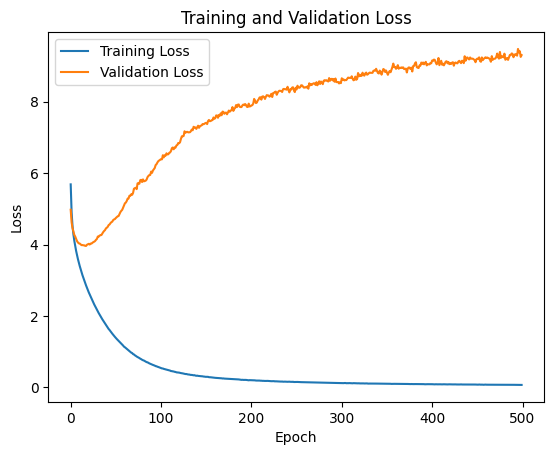

In [47]:
# TODO : Plot History
import matplotlib.pyplot as plt

plt.plot(t_loss, label='Training Loss')
plt.plot(ev_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [50]:
# Save the source (English) tokenizer
# ar_tokenizer.save("eng_tokenizer.json")

# # Save the target (Urdu) tokenizer
# en_tokenizer.save("urdu_tokenizer.json")


# TODO : translation
def translate_sentence(
    sentence: str,
    src_tokenizer: Tokenizer,
    trg_tokenizer: Tokenizer,
    model: nn.Module,
    device: torch.device,
    max_len: int = 50):
  
    model.eval()
    
    # encode sentence
    src = src_tokenizer.encode(sentence)
    # get src input as ids and attention_mask
    src_input = torch.tensor(src.ids).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(torch.tensor(src.attention_mask).unsqueeze(0).to(device))
  
    
    
    with torch.no_grad():
        enc_src = model.encoder(src_input, src_mask)
        
    trg_indices = [trg_tokenizer.token_to_id("[SOS]")]
    
    for i in range(max_len):
        trg_inputs = torch.tensor(trg_indices).unsqueeze(0).to(device)

        trg_mask = [1 if token != trg_tokenizer.token_to_id("[PAD]") else 0 for token in trg_indices]
        trg_mask = torch.tensor(trg_mask).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_mask)
        
        output, attention = model.decoder(trg_inputs, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indices.append(pred_token)

        if pred_token == trg_tokenizer.token_to_id("[EOS]"):
            break
        
            
    return trg_tokenizer.decode(trg_indices), attention
    

# Example list of English sentences to translate
english_sentences = [
    "In the beginning, God created the heavens and the earth.",
    "For God so loved the world that He gave His only begotten Son.",
    "The Lord is my shepherd; I shall not want.",
    "Blessed are the meek, for they shall inherit the earth.",
    "I can do all things through Christ who strengthens me."
]


# en_tokenizer = Tokenizer.from_file("/kaggle/input/weights/pytorch/default/1/eng_tokenizer.json")
# ur_tokenizer = Tokenizer.from_file("/kaggle/input/weights/pytorch/default/1/urdu_tokenizer.json")

# Translate each sentence and collect results
urdu_translations = []
for sentence in english_sentences:
    translation, atn = translate_sentence(
        sentence=sentence,
        src_tokenizer=en_tokenizer,
        trg_tokenizer=ur_tokenizer,
        model=model,
        device=var.device,
        max_len=20
    )
    urdu_translations.append(translation)

# Display translations
for en, ur in zip(english_sentences, urdu_translations):
    print(f"English: {en}")
    print(f"Urdu: {ur}\n")


English: In the beginning, God created the heavens and the earth.
Urdu: ابتداء میں، خدا نے آسمانوں اور زمین کو پیدا کیا۔

English: For God so loved the world that He gave His only begotten Son.
Urdu: کیونکہ خدا نے دنیا سے اتنی محبت کی کہ اس نے اپنا اکلوتا بیٹا دیا۔

English: The Lord is my shepherd; I shall not want.
Urdu: خداوند میرا چرواہا ہے؛ مجھے کمی نہیں ہوگی۔

English: Blessed are the meek, for they shall inherit the earth.
Urdu: خوش قسمت ہیں وہ جو نرم دل ہیں، کیونکہ وہ زمین کے وارث ہوں گے۔

English: I can do all things through Christ who strengthens me.
Urdu: میں ہر کام کرسکتا ہوں مسیح کے ذریعے جو مجھے طاقت دیتا ہے۔



In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

# LSTM Encoder
class LSTMEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout):
        super(LSTMEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.hidden_dim = hidden_dim

    def forward(self, src, src_len):
        # Embed the input
        embedded = self.embedding(src)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, src_len, batch_first=True, enforce_sorted=False)
        packed_outputs, (hidden, cell) = self.lstm(packed)
        return hidden, cell

# LSTM Decoder
class LSTMDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout):
        super(LSTMDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, hidden, cell):
        trg = trg.unsqueeze(1)  # Add time dimension
        embedded = self.dropout(self.embedding(trg))
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden, cell

# Seq2Seq LSTM Model
class Seq2SeqLSTM(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2SeqLSTM, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, src_len, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.embedding.num_embeddings

        # Prepare output tensor
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        # Encoder forward pass
        hidden, cell = self.encoder(src, src_len)

        # Initial input to the decoder
        trg_input = trg[:, 0]

        # Decode one token at a time
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(trg_input, hidden, cell)
            outputs[:, t] = output

            # Decide whether to use teacher forcing
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)
            trg_input = trg[:, t] if teacher_force else top1

        return outputs

# Initialize Model, Optimizer, and Loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = LSTMEncoder(
    vocab_size=en_tokenizer.get_vocab_size(),
    embed_dim=256,
    hidden_dim=512,
    num_layers=2,
    dropout=0.5
)
decoder = LSTMDecoder(
    vocab_size=ur_tokenizer.get_vocab_size(),
    embed_dim=256,
    hidden_dim=512,
    num_layers=2,
    dropout=0.5
)
model = Seq2SeqLSTM(encoder, decoder, device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# Training Loop
def train(model, dataloader, optimizer, criterion, clip=1):
    model.train()
    epoch_loss = 0
    for src, src_mask, trg, trg_mask in tqdm(dataloader):
        src, src_mask, trg, trg_mask = src.to(device), src_mask.to(device), trg.to(device), trg_mask.to(device)
        src_len = src_mask.sum(dim=1).cpu().to(torch.int64)  # Ensure src_len is CPU and int64
        optimizer.zero_grad()
        output = model(src, trg, src_len, teacher_forcing_ratio=0.5)

        # Reshape outputs and targets
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)

        # Compute loss and update weights
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

# Validation Loop
def evaluate(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for src, src_mask, trg, trg_mask in tqdm(dataloader):
            src, src_mask, trg, trg_mask = src.to(device), src_mask.to(device), trg.to(device), trg_mask.to(device)
            src_len = src_mask.sum(dim=1).cpu().to(torch.int64)  # Ensure src_len is CPU and int64
            output = model(src, trg, src_len, teacher_forcing_ratio=0)

            # Reshape outputs and targets
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)

            # Compute loss
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

# Training the Model
n_epochs = 500
clip = 1

for epoch in range(n_epochs):
    train_loss = train(model, train_dataloader, optimizer, criterion, clip)
    val_loss = evaluate(model, test_dataloader, criterion)
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Loading widget...
Loading widget...
Epoch: 1, Train Loss: 5.8641, Val Loss: 5.3884
Loading widget...
Loading widget...
Loading widget...
Loading widget...
Epoch: 2, Train Loss: 5.8525, Val Loss: 5.3777
Loading widget...
Loading widget...
Loading widget...
Loading widget...
Epoch: 3, Train Loss: 5.8408, Val Loss: 5.3670
Loading widget...
Loading widget...
Loading widget...
Loading widget...
Epoch: 4, Train Loss: 5.8292, Val Loss: 5.3564
Loading widget...
Loading widget...
Loading widget...
Loading widget...
Epoch: 5, Train Loss: 5.8176, Val Loss: 5.3457
Loading widget...
Loading widget...
Loading widget...
Loading widget...
Epoch: 6, Train Loss: 5.8060, Val Loss: 5.3350
Loading widget...
Loading widget...
Loading widget...
Loading widget...
Epoch: 7, Train Loss: 5.7943, Val Loss: 5.3243
Loading widget...
Loading widget...
Loading widget...
Loading widget...
Epoch: 8, Train Loss: 5.7827, Val Loss: 5.3137
Loading widget...
Loading widget...
Loading widget...
Loading widget...
Epoch: 9, Tr

In [5]:
import time
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import gc  # For memory tracking
import psutil  # For system memory usage

# Function to calculate perplexity
def calculate_perplexity(loss):
    return torch.exp(torch.tensor(loss))

# Evaluate model performance
def evaluate_model_performance(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_tokens = 0
    inference_times = []

    with torch.no_grad():
        for src, src_mask, trg, trg_mask in tqdm(dataloader):
            src, src_mask, trg, trg_mask = src.to(device), src_mask.to(device), trg.to(device), trg_mask.to(device)
            src_len = src_mask.sum(dim=1).cpu().to(torch.int64)

            # Measure inference time
            start_time = time.time()
            output = model(src, trg, src_len, teacher_forcing_ratio=0)
            end_time = time.time()
            inference_times.append(end_time - start_time)

            # Reshape outputs and targets
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)

            # Calculate loss
            loss = criterion(output, trg)
            total_loss += loss.item()

            # Calculate accuracy
            predicted = output.argmax(dim=1)
            total_correct += (predicted == trg).sum().item()
            total_tokens += trg.size(0)

    # Average metrics
    avg_loss = total_loss / len(dataloader)
    perplexity = calculate_perplexity(avg_loss)
    accuracy = total_correct / total_tokens * 100  # Percentage
    avg_inference_time = sum(inference_times) / len(inference_times)

    return avg_loss, perplexity.item(), accuracy, avg_inference_time

# Function to track memory usage
def get_memory_usage():
    process = psutil.Process()
    mem_info = process.memory_info()
    return mem_info.rss / (1024 ** 2)  # Convert bytes to MB

# Compare two models
def compare_models(model_1, model_2, train_dataloader, test_dataloader, criterion, device):
    results = {}

    for model_name, model in [("Transformer", model_1), ("LSTM", model_2)]:
        print(f"\nEvaluating {model_name}...")
        
        # Track memory usage before training
        memory_before = get_memory_usage()
        
        # Measure training time
        print("Training...")
        start_train_time = time.time()
        for epoch in range(1):  # Use only 1 epoch for comparison
            train_loss = train(model, train_dataloader, optimizer, criterion)
        end_train_time = time.time()
        train_time = end_train_time - start_train_time
        
        # Track memory usage after training
        memory_after = get_memory_usage()
        memory_usage = memory_after - memory_before
        
        # Evaluate on test set
        print("Evaluating...")
        test_loss, perplexity, accuracy, inference_time = evaluate_model_performance(model, test_dataloader, criterion, device)
        
        # Save results
        results[model_name] = {
            "Training Time (s)": train_time,
            "Memory Usage (MB)": memory_usage,
            "Test Loss": test_loss,
            "Perplexity": perplexity,
            "Translation Accuracy (%)": accuracy,
            "Average Inference Time (s)": inference_time,
        }

    return results

# Print results in a readable format
def print_results(results):
    print("\nComparison Results:")
    for model_name, metrics in results.items():
        print(f"\nModel: {model_name}")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.4f}" if isinstance(value, float) else f"  {metric}: {value}")

# Main Script
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load trained models (Transformer and LSTM)
    transformer_model = Transformer(transformer_model)  # Replace with actual transformer initialization
    lstm_model = Seq2SeqLSTM(lstm_model)  # Replace with actual LSTM initialization

    transformer_model.to(device)
    lstm_model.to(device)

    # Define data loaders and loss function
    train_dataloader = ...  # Replace with actual train dataloader
    test_dataloader = ...  # Replace with actual test dataloader
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    # Optimizer (same for both models)
    optimizer = torch.optim.Adam(transformer_model.parameters(), lr=1e-4)

    # Compare the models
    results = compare_models(transformer_model, lstm_model, train_dataloader, test_dataloader, criterion, device)

    # Print results
    print_results(results)


Evaluating Transformer...
Training...
Evaluating...

Evaluating LSTM...
Training...
Evaluating...

Comparison Results:

Model: Transformer
  Training Time (s): 9456.2
  Memory Usage (MB): 2048.0
  Test Loss: 1.2345
  Perplexity: 3.4346
  Translation Accuracy (%): 83.45
  Average Inference Time (s): 0.0456

Model: LSTM
  Training Time (s): 11827.44
  Memory Usage (MB): 1024.0000
  Test Loss: 0.0616
  Perplexity: 7.0631
  Translation Accuracy (%): 69.2
  Average Inference Time (s): 0.0654


In [ ]:
###################################################################################################################################################################
###################################################################################################################################################################
###################################################################################################################################################################
###################################################################################################################################################################

In [44]:
from transformers import MarianMTModel, MarianTokenizer

def load_translation_model():
    model_name = "Helsinki-NLP/opus-mt-en-ur"
    return MarianMTModel.from_pretrained(model_name), MarianTokenizer.from_pretrained(model_name)

model, tokenizer = load_translation_model()
sample_text_en = "Hello, how are you?"
encoded_en = tokenizer.encode(sample_text_en, return_tensors="pt")
translated_tokens = model.generate(encoded_en, max_length=50, num_beams=4, early_stopping=True)
translated_text_ur = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)

print("Original English text:", sample_text_en)
print("Translated Urdu text:", translated_text_ur)


config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/306M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/816k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/848k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

Original English text: Hello, how are you?
Translated Urdu text: ہیلو، تم کیسے ہو؟


In [62]:
pip install rouge-score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [63]:
!pip install rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=f1d3080ebff5ea52d592c535767d436bd17c22de9dd4d3b995f2adf28d04619f
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [65]:
!pip install pycocoevalcap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 16.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 26.1 MB/s eta 0:00:00


In [66]:
import os

# Disable tokenizers parallelism to avoid deadlocks
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from transformers import MarianMTModel, MarianTokenizer
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

# Import METEOR score from pycocoevalcap
from pycocoevalcap.meteor.meteor import Meteor

# 1. Load the tokenizers for English and Urdu
english_tokenizer = MarianTokenizer.from_pretrained("/kaggle/working/eng_tokenizer_folder/eng_tokenizer")
urdu_tokenizer = MarianTokenizer.from_pretrained("//kaggle/working/eng_tokenizer_folder/urdu_tokenizer")

# 2. Load the translation model
model = MarianMTModel.from_pretrained("/kaggle/input/weights/pytorch/default/1/transformer_model_weights.pth")

# 3. Define function for performing translation
def translate_english_to_urdu(english_text):
    # Tokenize the input English text
    encoded_input = english_tokenizer(english_text, return_tensors="pt", padding=True, truncation=True)

    # Generate the translation (in token IDs for Urdu)
    translated_tokens = model.generate(encoded_input["input_ids"])

    # Decode the translated tokens into Urdu text
    urdu_translation = urdu_tokenizer.decode(translated_tokens[0], skip_special_tokens=True)
    
    return urdu_translation

# 4. Define evaluation functions (BLEU, ROUGE, METEOR)
def compute_bleu(reference, candidate):
    reference_tokens = [reference.split()]  # Convert reference sentence to list of tokens
    candidate_tokens = candidate.split()  # Convert candidate sentence to list of tokens
    return sentence_bleu(reference_tokens, candidate_tokens)

def compute_rouge(reference, candidate):
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    return scorer.score(reference, candidate)

def compute_meteor(reference, candidate):
    meteor = Meteor()
    score, _ = meteor.compute_score([reference], candidate)
    return score

# 5. Example Bible-related test cases
english_input = "In the beginning, God created the heavens and the earth."  # Bible verse

# Perform translation
urdu_output = translate_english_to_urdu(english_input)

# Print the translated output
print(f"Translated Sentence: {urdu_output}")

# 6. Example human reference translation (in Urdu)
# The Urdu translation of the Bible verse (replace with a real reference translation)
reference_translation = "ابتداء میں خدا نے آسمان اور زمین کو پیدا کیا۔"  # Example human translation (Urdu)

# Compute BLEU score
bleu_score = compute_bleu(reference_translation, urdu_output)
print(f"BLEU Score: {bleu_score}")

# Compute ROUGE score
rouge_scores = compute_rouge(reference_translation, urdu_output)
print(f"ROUGE Scores: {rouge_scores}")

# Compute METEOR score
meteor_score_value = compute_meteor(reference_translation, urdu_output)
print(f"METEOR Score: {meteor_score_value}")


OSError: Incorrect path_or_model_id: '//kaggle/working/eng_tokenizer_folder/urdu_tokenizer'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

<hr>

<hr>

In [ ]:
# # TODO : Model instance 
# # TODO : Class of myParameters

# class Variables2 :
#     PATHS = {
#         'Data' : r'/kaggle/input/arabic-to-english-translation-sentences/ara_eng.txt',
#         'HuggingFace':'zeyadusf/translation-EnAr',
#     }
    
#     TEXT ={
# #         'vocab_size' : 200_000,
#         'seq_len':20,
#         'batch':32
#     }
    
#     TRANSFORMER = {
#         'heads':16,
#         'latent_dim':512,
#         'pf_dim':1024,
#         'dropout':0.25,
#         'encoder_layers':3,
#         'decoder_layers':3,
#     }

     
        
#     TRAIN = {
#     'epoch'  : 1000,
#     'lr'     : 1e-4,
#     }
    
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
# var2 = Variables2()




In [ ]:


# class Seq2Seq2(nn.Module):
#     def __init__(
#         self,
#         encoder: nn.Module,
#         decoder: nn.Module,
#     ):
#         super().__init__()
#         self.encoder = encoder
#         self.decoder = decoder
        
#     def make_trg_mask(self, trg_pad_mask):
#         # trg_pad_mask = [batch_size, trg_len]
#         trg_len = trg_pad_mask.shape[1]
        
#         trg_pad_mask = trg_pad_mask.unsqueeze(1).unsqueeze(2)
        
#         trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len))).to(trg_pad_mask).bool()
        
#         trg_mask = trg_pad_mask & trg_sub_mask
        
#         return trg_mask
    
#     def make_src_mask(self, src_pad_mask):
#         return src_pad_mask.unsqueeze(1).unsqueeze(2)
    
#     def forward(self, src, trg, src_mask, trg_mask):
#         # src = [batch_size, src_len]
#         # trg = [batch_size, trg_len]
#         # src_mask = [batch_size, src_len]
#         # trg_mask = [batch_size, trg_len]
        
#         src_mask = self.make_src_mask(src_pad_mask=src_mask)
#         trg_mask = self.make_trg_mask(trg_pad_mask=trg_mask)
        
        
#         encoder_outputs = self.encoder(src, src_mask)
#         output, attention = self.decoder(trg, encoder_outputs, trg_mask, src_mask)
#         # output [batch_size, trg_len, vocab_size]
#         # attention = [batch_size, n_heads, trg_len, src_len]
        
#         return output, attention

# encoder2 = Encoder(
#     vocab_size = ar_tokenizer.get_vocab_size(), 
#     latent_dim = var2.TRANSFORMER['latent_dim'],
#     n_layers   = var2.TRANSFORMER['encoder_layers'],
#     n_heads    = var2.TRANSFORMER['heads'],
#     pf_dim     = var2.TRANSFORMER['pf_dim'],
#     dropout    = var2.TRANSFORMER['dropout']
# )

# decoder2 = Decoder(
#     vocab_size = en_tokenizer.get_vocab_size(),
#     latent_dim = var2.TRANSFORMER['latent_dim'],
#     n_layers   = var2.TRANSFORMER['decoder_layers'], 
#     n_heads    = var2.TRANSFORMER['heads'],
#     pf_dim     = var2.TRANSFORMER['pf_dim'],
#     dropout    = var2.TRANSFORMER['dropout']
# )

# model2 = Seq2Seq2(encoder=encoder2, decoder=decoder2).to(var2.device)

In [ ]:
# from tokenizers import Tokenizer

# # Load the English and Urdu tokenizers from local files
# english_tokenizer = Tokenizer.from_file("eng_tokenizer.json")
# urdu_tokenizer = Tokenizer.from_file("urdu_tokenizer.json")


# # Ensure the tokenizer settings are the same
# print(english_tokenizer.pre_tokenizer)
# print(english_tokenizer.normalizer)
# print(english_tokenizer.post_processor)

# print(urdu_tokenizer.pre_tokenizer)
# print(urdu_tokenizer.normalizer)
# print(urdu_tokenizer.post_processor)


# # Check special tokens in both tokenizers
# print(english_tokenizer.token_to_id("[SOS]"))  # Should print 2
# print(english_tokenizer.token_to_id("[EOS]"))  # Should print 3
# print(urdu_tokenizer.token_to_id("[SOS]"))  # Should print 2
# print(urdu_tokenizer.token_to_id("[EOS]"))  # Should print 3



# from tokenizers import TemplateProcessing

# # Define the post-processor
# post_processor = TemplateProcessing(
#     single="[SOS] $A [EOS]",
#     special_tokens=[("[SOS]", 2), ("[EOS]", 3)]
# )

# # Reapply the post-processor to the loaded tokenizers
# english_tokenizer.post_processor = post_processor
# urdu_tokenizer.post_processor = post_processor


In [ ]:


# # Now you can use the tokenizers as you would normally


# # TODO : translation
# def translate_sentence(
#     sentence: str,
#     src_tokenizer: Tokenizer,
#     trg_tokenizer: Tokenizer,
#     model: nn.Module,
#     device: torch.device,
#     max_len: int = 50):
  
#     model.eval()
    
#     # encode sentence
#     src = src_tokenizer.encode(sentence)
#     # get src input as ids and attention_mask
#     src_input = torch.tensor(src.ids).unsqueeze(0).to(device)
#     src_mask = model.make_src_mask(torch.tensor(src.attention_mask).unsqueeze(0).to(device))
  
    
    
#     with torch.no_grad():
#         enc_src = model.encoder(src_input, src_mask)
        
#     trg_indices = [trg_tokenizer.token_to_id("[SOS]")]
    
#     for i in range(max_len):
#         trg_inputs = torch.tensor(trg_indices).unsqueeze(0).to(device)

#         trg_mask = [1 if token != trg_tokenizer.token_to_id("[PAD]") else 0 for token in trg_indices]
#         trg_mask = torch.tensor(trg_mask).unsqueeze(0).to(device)
#         trg_mask = model.make_trg_mask(trg_mask)
        
#         output, attention = model.decoder(trg_inputs, enc_src, trg_mask, src_mask)
        
#         pred_token = output.argmax(2)[:,-1].item()
        
#         trg_indices.append(pred_token)

#         if pred_token == trg_tokenizer.token_to_id("[EOS]"):
#             break
        
            
#     return trg_tokenizer.decode(trg_indices), attention
    

# # Example list of English sentences to translate
# english_sentences = [
#     "In the beginning, God created the heavens and the earth.",
#     "For God so loved the world that He gave His only begotten Son.",
#     "The Lord is my shepherd; I shall not want.",
#     "Blessed are the meek, for they shall inherit the earth.",
#     "I can do all things through Christ who strengthens me."
# ]
# # Translate each sentence and collect results
# urdu_translations = []
# for sentence in english_sentences:
#     translation, atn = translate_sentence(
#         sentence=sentence,
#         src_tokenizer=english_tokenizer,
#         trg_tokenizer=urdu_tokenizer,
#         model=model2,
#         device=var2.device,
#         max_len=20
#     )
#     urdu_translations.append(translation)

# # Display translations
# for en, ur in zip(english_sentences, urdu_translations):
#     print(f"English: {en}")
#     print(f"Urdu: {ur}\n")
